In [144]:
# Packages used
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import graphviz
import optuna
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from optuna.samplers import TPESampler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
def distplots(X, kde=True):

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))
    
    plt.suptitle("Distribution of Continuous variables", fontsize=18, y = 1)

    for i, ax in enumerate(fig.axes):
        if i < p:
            sns.histplot(X.iloc[:,i], ax=ax, stat='density', kde=False, edgecolor ='black')
            sns.kdeplot(X.iloc[:,i], ax=ax, alpha= 0.0, color='blue')
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            ax.set_title(labels[i])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

# reference: QBUS6810 Tutorial

In [4]:
def coefplot(model, labels):
    coef = model.coef_
    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    all_ = True
    if len(table) > 20:
        reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
        reference = reference.iloc[:20]
        table = table[reference.index]
        table = table.sort_values(ascending=True, inplace=False)
        all_ = False
        

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    if all_:
        ax.set_title('Estimated coefficients', fontsize=14)
    else: 
        ax.set_title('Estimated coefficients (20 largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

# reference: QBUS6810 Tutorial

In [ ]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork',context='notebook', ticks=True, grid=False, fscale=1.4,figsize=(9, 6))

# 1. Read in the Data

In [5]:
# View data
df = pd.read_csv('Sherpa_dataset.csv')
df.head()

,Deliveries ID,Deliveries User ID,Customers Category Name,Deliveries State Name,Deliveries Delivery Option Name,Deliveries Distance In Meters,Deliveries Duration In Seconds,Deliveries Amount,Deliveries Delivery Price,Deliveries Refund Amount,...,Deliveries Fragile (Yes / No),Deliveries Future Job (Yes / No),Delivery Details Pickup Postal Code,Delivery Details Pickup State Code,Delivery Details Pickup Metro Area,Delivery Details Pickup Location,Delivery Details Drop Off Postal Code,Delivery Details Drop Off State Code,Delivery Details Drop Off Metro Area,Delivery Details Drop Off Location
0,4669796,27237,Alcohol,closed,1 hour,"1,543",324,$18.51,$13.89,$0.00,...,No,No,3128.0,VIC,Melbourne,"'-37.8190938,145.1221019",3128,VIC,Melbourne,"'-37.828301,145.1272158"
1,4669793,27237,Alcohol,closed,1 hour,730,173,$15.50,$11.63,$0.00,...,No,No,3194.0,VIC,Melbourne,"'-37.9815041,145.0631414",3194,VIC,Melbourne,"'-37.9827959,145.0578174"
2,4662566,45440,Grocery/Food,closed,1 hour,"7,432",699,$40.03,$30.01,$0.00,...,No,Yes,3150.0,VIC,Melbourne,"'-37.8762186,145.1652513",3152,VIC,Melbourne,"'-37.8865433,145.2356254"
3,4669670,27237,Alcohol,closed,1 hour,368,102,$15.50,$11.63,$0.00,...,No,No,3121.0,VIC,Melbourne,"'-37.8254207,144.9942752",3121,VIC,Melbourne,"'-37.826117,144.998071"
4,4667379,45440,Grocery/Food,cancelled,1 hour,"1,303",270,$14.50,$0.00,$14.50,...,No,No,4119.0,QLD,Brisbane,"'-27.606905,153.1100234",4119,QLD,Brisbane,"'-27.6052348,153.1116114"


In [6]:
df.shape

(495261, 38)

In [7]:
# Data types of columns and shape
# Some columns are classified incorrectly and will be transformed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495261 entries, 0 to 495260
Data columns (total 38 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Deliveries ID                                   495261 non-null  int64  
 1   Deliveries User ID                              495261 non-null  int64  
 2   Customers Category Name                         495261 non-null  object 
 3   Deliveries State Name                           495261 non-null  object 
 4   Deliveries Delivery Option Name                 495261 non-null  object 
 5   Deliveries Distance In Meters                   495261 non-null  object 
 6   Deliveries Duration In Seconds                  495261 non-null  object 
 7   Deliveries Amount                               495261 non-null  object 
 8   Deliveries Delivery Price                       495261 non-null  object 
 9   Deliveries Refund Amount  

# 2. Data Prelimnary Preparation

In [8]:
# data copy
sherpa = df.copy()

## 2.1 Data transformation

- According to dtype, some columns are classified into wrong dtypes, such as Deliveries Distance In Meters, Deliveries Duration In Seconds, Deliveries Amount, Deliveries Delivery Price, Deliveries Refund Amount, Delivery Details Drop Off Postal Code. 

- However, the for the Delivery Details Pickup Postal Code, we will transformed it once we have handle the missing values.

- The time columns will also be transformed to datetime 
(Deliveries Created Time, Deliveries Ready At Time, Deliveries Assigned At Time, Deliveries Delivered At Time, Deliveries Deliver for Time)


In [9]:
# Deliveries Distance In Meters
sherpa['Deliveries Distance In Meters']=sherpa['Deliveries Distance In Meters'].str.replace(',','').astype('int64')

# Deliveries Duration In Seconds
sherpa['Deliveries Duration In Seconds']=sherpa['Deliveries Duration In Seconds'].str.replace(',','').astype('int64')

# Deliveries Amount
sherpa['Deliveries Amount']=sherpa['Deliveries Amount'].str.replace('$','').astype('float64')

# Deliveries Delivery Price
sherpa['Deliveries Delivery Price']=sherpa['Deliveries Delivery Price'].str.replace('$','').astype('float64')

#Deliveries Refund Amount
sherpa['Deliveries Refund Amount']=sherpa['Deliveries Refund Amount'].str.replace('$','').astype('float64')

# https://pandas.pydata.org/pandas-docs/version/0.23.4/text.html

In [10]:
# convert string type to timestamp
convert_to_time_list = sherpa.loc[:, 'Deliveries Created Time':'Deliveries Deliver for Time']
for i in convert_to_time_list:
    sherpa[i]=pd.to_datetime(sherpa[i],format='%d/%m/%Y %H:%M',errors='ignore')

    #1/10/2021 0:55 %d/%m/%Y %H%M
    
sherpa['Deliveries Delivered At Time'][0]

Timestamp('2021-10-01 00:55:00')

## 2.2 Feature Creation

As an industry benchmark, a key performance indicator that is used to measure jobs delivery on time is **Delivery in Full, on Time (DIFOT)**.

Sherpa classifies a delivery as DIFOT by comparing the ‘Deliveries Delivered at Time’ (the actual time the delivery was made) vs ‘Deliveries Deliver for Time’ (the target time for the delivery), with a buffer of 15 minutes. More specifically:

    • If the ‘Deliveries Delivered at Time’ is more than 15 minutes late relative to the ‘Deliveries Deliver for Time’, then the delivery is not DIFOT.

    • Otherwise, the delivery is DIFOT.

Note: a DIFOT value (yes/no) should only be computed **for deliveries that have both ‘closed’
under ‘Deliveries State Name’ and a non-null value under ‘Deliveries Delivered At Time’.** In
particular, do not compute a DIFOT value for deliveries that have ‘cancelled’, ‘failed’ or
‘refunded’ under ‘Deliveries State Name’.

In [11]:
sherpa['Deliveries State Name'].value_counts()

closed       441863
cancelled     46199
failed         6779
refunded        420
Name: Deliveries State Name, dtype: int64

In [12]:
# only Deliveries State Name 'closed' will be used for determining DIFOT
sherpa = sherpa[(sherpa['Deliveries State Name'] == 'closed')]

In [13]:
# check missing values in Deliveries Delivered At Time
sherpa['Deliveries Delivered At Time'].isnull().sum()

9

In [14]:
# drop the missing values at the Deliveries Delivered At Time column
sherpa = sherpa[sherpa['Deliveries Delivered At Time'].notna()]

In [15]:
def difference(time):
    return (time['Deliveries Delivered At Time'] - time['Deliveries Deliver for Time']).total_seconds()/60

sherpa['Time_Diff'] = sherpa.apply(difference, axis=1)

In [16]:
# create DIFOT column and if DIFOT = 1, Not DIFOT = 0
def check(difot):
    if difot['Time_Diff']> 15:
        return 0
    else:
        return 1

sherpa['DIFOT'] = sherpa.apply(check, axis=1)

In [17]:
# Proportion of DIFOT --> imbalanced(might need different metrics for model selection)
print('DIFOT = {}%'.format(round((sherpa['DIFOT']==1).sum()/sherpa['DIFOT'].shape[0]*100,0)))
print('Not DIFOT = {}%'.format(round((sherpa['DIFOT']==0).sum()/sherpa['DIFOT'].shape[0]*100,0)))

DIFOT = 92.0%
Not DIFOT = 8.0%


In [18]:
# create a new column to display the time difference specifically for late deliveries
def late(delivery):
  if delivery['DIFOT'] == 1:
    return 0
  else:
    return delivery['Time_Diff']

sherpa['Time_Delta'] = sherpa.apply(late, axis =1)

In [19]:
sherpa = sherpa.drop('Time_Diff', axis = 1)

## 2.3 Drop unecessary columns

- Drop the 2 ID columns as they are meaningless to DIFOT as each of them are unique. 
- Drop the Deliveries Refund Amount as all 'closed' deliveries do not have any refund amount because no delivery was cancelled.
- Drop all the time columns as we no longer require it.
- Drop the Deliveries Heaviest Item Weight have several missing values. Thus, it is appropriate to drop the entire column, since there are too many missing values, any data imputation will generate strong bias.
- Remove the Hourly rate option in the Deliveries Delivery Option Name as it is not relevant for the analysis.
- We no longer need the Deliveries State Name column as all deliveries have state name 'closed' now.  
- Drop the Deliveries Total Weight as most of it is missing and as it is only applicable for the Grocery/Food Category.

In [20]:
sherpa = sherpa.drop(['Deliveries ID','Deliveries User ID','Deliveries State Name','Deliveries Refund Amount', 
                      'Deliveries Created Time', 'Deliveries Ready At Time', 'Deliveries Delivered At Time', 
                      'Deliveries Deliver for Time', 'Deliveries Assigned At Time', 'Deliveries Heaviest Item Weight',
                      'Deliveries Total Weight'], axis = 1)

In [21]:
sherpa.drop(sherpa.index[sherpa['Deliveries Delivery Option Name'] == 'Hourly rate'], inplace=True)

## 2.4 Missing Values

In [22]:
(sherpa.isnull().sum()/sherpa.shape[0]).sort_values(ascending=False).head(10)

Delivery Details Pickup Postal Code      0.002021
Delivery Details Drop Off Metro Area     0.000321
Delivery Details Drop Off Postal Code    0.000048
Delivery Details Drop Off State Code     0.000002
Delivery Details Pickup Metro Area       0.000002
Customers Category Name                  0.000000
Deliveries Item Number                   0.000000
DIFOT                                    0.000000
Delivery Details Drop Off Location       0.000000
Delivery Details Pickup Location         0.000000
dtype: float64

**2.4.1 Location Details**

- We will drop the missing values at the Delivery Details Pickup Postal Code and Delivery Details Drop Off Postal Code as there are only 0.2% missing values. If we manually imputate the data, it is time consuming and costly. Thus, dropping this column might be a good idea.  **(This could be a limitation in reflection)**


- Since there is only one missing value in the Delivery Details Pickup Metro Area, and the state code is NSW. Thus, we decide to impute the missing value with Sydney and which is also the mode of NSW.


- Since there is only one missing value at the Delivery Details Drop Off State Code, this delivery metro area is Adelaide, thus it is appropriate to impute SA as its state code.


- Since the pickup postal code is similar to the dropoff code, therefore the Drop Off Metro Area should be equal to Pickup Metro Area.


In [23]:
# Delivery Details Pickup Postal Code and the Delivery Details Drop Off Postal Code
sherpa=sherpa.dropna(axis=0,subset=['Delivery Details Drop Off Postal Code', 'Delivery Details Pickup Postal Code'])

In [24]:
# Convert the Delivery Details Drop Off Postal Code to str first 
sherpa['Delivery Details Drop Off Postal Code']=sherpa['Delivery Details Drop Off Postal Code'].astype(str)

In [25]:
# To remove the decimal points on some of the Drop Off Postal Code
def length(dropoff):
    if len(dropoff['Delivery Details Drop Off Postal Code']) == 4:
        return dropoff['Delivery Details Drop Off Postal Code']
    else:
        return dropoff['Delivery Details Drop Off Postal Code'].replace('.','')[:4]

sherpa['Delivery Details Drop Off Postal Code'] = sherpa.apply(length, axis = 1)

In [26]:
# Convert both the Postal Code to int
sherpa['Delivery Details Drop Off Postal Code'] = sherpa['Delivery Details Drop Off Postal Code'].astype(int)
sherpa['Delivery Details Pickup Postal Code'] = sherpa['Delivery Details Pickup Postal Code'].astype(int)

In [27]:
# Delivery Details Pickup Metro Area
sherpa['Delivery Details Pickup Metro Area']=sherpa['Delivery Details Pickup Metro Area'].fillna('Sydney')

In [28]:
# Delivery Details Drop Off State Code
sherpa['Delivery Details Drop Off State Code']=sherpa['Delivery Details Drop Off State Code'].fillna('SA')

In [29]:
# Delivery Details Drop Off Metro Area
sherpa['Delivery Details Drop Off Metro Area']=sherpa['Delivery Details Drop Off Metro Area'].fillna(
    sherpa['Delivery Details Pickup Metro Area'][sherpa['Delivery Details Drop Off Metro Area'].isnull()])

- The Deliveries Time Zone column will be dropped as it has the exact same information as the Deliveries Details Pickup State Code values

In [30]:
sherpa['Deliveries Time Zone'].value_counts()

Australia/Sydney       153345
Australia/Melbourne    120600
Australia/Brisbane      73877
Australia/Adelaide      32928
Australia/Perth         28023
Australia/Canberra      19718
Australia/Hobart        12422
Name: Deliveries Time Zone, dtype: int64

In [31]:
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Sydney", "NSW")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Melbourne", "VIC")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Brisbane", "QLD")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Adelaide", "SA")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Perth", "WA")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Canberra", "ACT")
sherpa['Deliveries Time Zone']= sherpa['Deliveries Time Zone'].replace("Australia/Hobart", "TAS")

In [32]:
sherpa['Deliveries Time Zone'].equals(sherpa['Delivery Details Pickup State Code'])

True

In [33]:
sherpa = sherpa.drop(['Deliveries Time Zone'], axis = 1)

## 2.5 Separate the latitude and longitude details

In [34]:
sherpa['Delivery Details Pickup Location']= sherpa['Delivery Details Pickup Location'].apply(lambda x: x.replace("'",''))
sherpa['Delivery Details Drop Off Location']= sherpa['Delivery Details Drop Off Location'].apply(lambda x: x.replace("'",''))

In [35]:
sherpa['Pickup Latitude'] = sherpa['Delivery Details Pickup Location'].str.split(',').str[0]
sherpa['Pickup Longitude'] = sherpa['Delivery Details Pickup Location'].str.split(',').str[1]
sherpa['Drop off Latitude'] = sherpa['Delivery Details Drop Off Location'].str.split(',').str[0]
sherpa['Drop off Longitude'] = sherpa['Delivery Details Drop Off Location'].str.split(',').str[1]

In [36]:
sherpa = sherpa.drop(['Delivery Details Pickup Location', 'Delivery Details Drop Off Location'], axis = 1)

In [37]:
sherpa['Pickup Latitude'] = sherpa['Pickup Latitude'].astype(float)
sherpa['Pickup Longitude'] = sherpa['Pickup Longitude'].astype(float)
sherpa['Drop off Latitude'] = sherpa['Drop off Latitude'].astype(float)
sherpa['Drop off Longitude'] = sherpa['Drop off Longitude'].astype(float)

# 3. Exploratory Data Analysis

In [38]:
categorical = ['Customers Category Name', 'Deliveries Delivery Option Name',
               'Delivery Details Pickup State Code', 'Delivery Details Pickup Metro Area',  
               'Delivery Details Drop Off State Code','Delivery Details Drop Off Metro Area']

continuous = ['Deliveries Distance In Meters', 'Deliveries Duration In Seconds', 'Deliveries Amount', 
              'Deliveries Delivery Price', 'Delivery Surcharges Amount Increase',
              'Delivery Surcharges Delivery Price Increase', 'Delivery Surcharges Cbd User', 
              'Delivery Surcharges Cbd Courier', 'Delivery Surcharges Multiple Items User',
              'Delivery Surcharges Multiple Items Courier', 'Delivery Surcharges Wait Time Courier Increase',
              'Delivery Surcharges Wait Time User Increase', 'Delivery Surcharges Insurance User', 
              'Deliveries Item Number']

postal = ['Delivery Details Pickup Postal Code', 'Delivery Details Drop Off Postal Code']

binary = ['Deliveries Fragile (Yes / No)', 'Deliveries Future Job (Yes / No)']

location = ['Pickup Latitude', 'Pickup Longitude', 'Drop off Latitude', 'Drop off Longitude']

response = ['DIFOT']

## 3.1 Univariate Analysis

### 3.1.1 Response Variables

In [39]:
DIFOT_count = sherpa['DIFOT'].value_counts()

Text(0.5, 0, 'DIFOT/Not DIFOT')

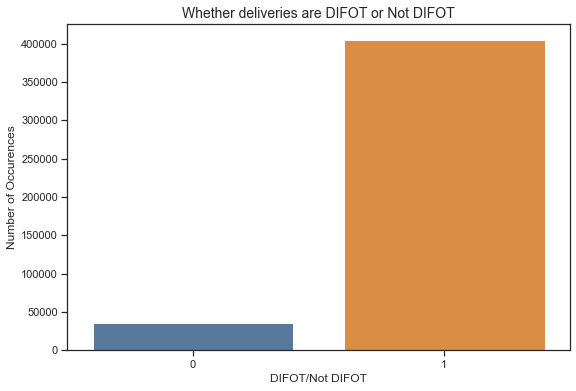

In [40]:
plt.figure(figsize=(9,6))

sns.barplot(DIFOT_count.index, DIFOT_count.values)
plt.title('Whether deliveries are DIFOT or Not DIFOT', fontsize = 14)
plt.ylabel('Number of Occurences')
plt.xlabel('DIFOT/Not DIFOT')

### 3.1.2 Continuous Variables

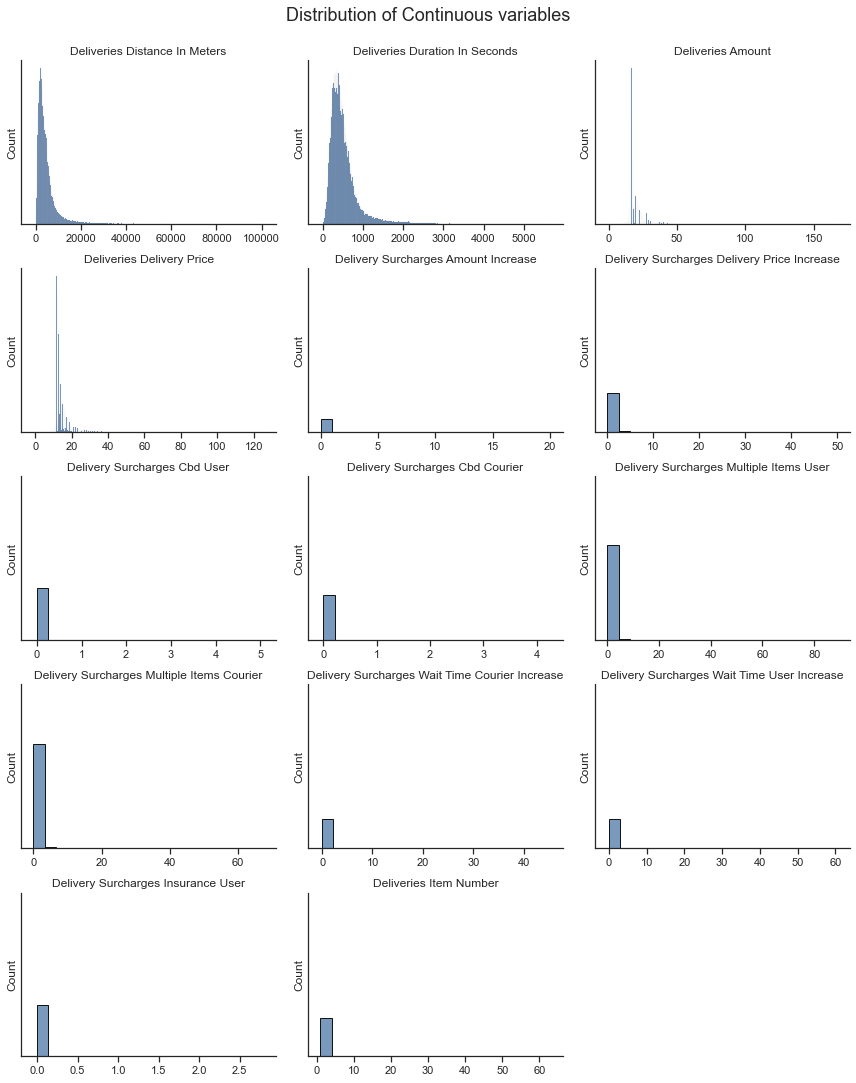

In [41]:
distplots(sherpa[continuous]) 
#plt.savefig('continuous bivar.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'Delivery Details Pickup Postal Code')

<Figure size 648x432 with 0 Axes>

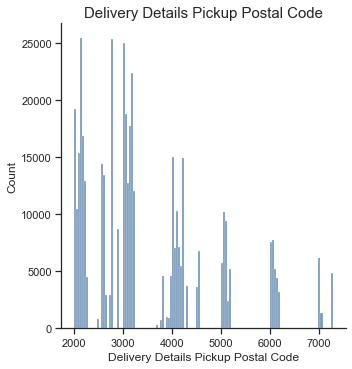

In [42]:
plt.figure(figsize = (9, 6))

sns.displot(data=sherpa,x='Delivery Details Pickup Postal Code',stat='count')
plt.ylabel('Count'); plt.title('Delivery Details Pickup Postal Code',fontsize = 15)

Text(0.5, 1.0, 'Delivery Details Drop Off Postal Code')

<Figure size 648x432 with 0 Axes>

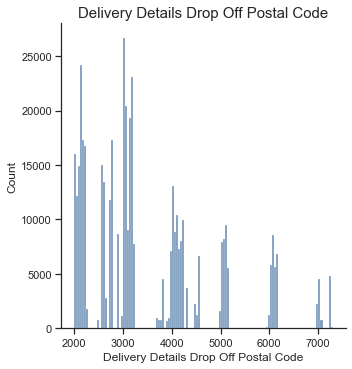

In [43]:
plt.figure(figsize = (9, 6))

sns.displot(data=sherpa,x='Delivery Details Drop Off Postal Code',stat='count')
plt.xlabel('Delivery Details Drop Off Postal Code'); plt.ylabel('Count'); plt.title('Delivery Details Drop Off Postal Code',fontsize =15)

### 3.1.3 Categorical

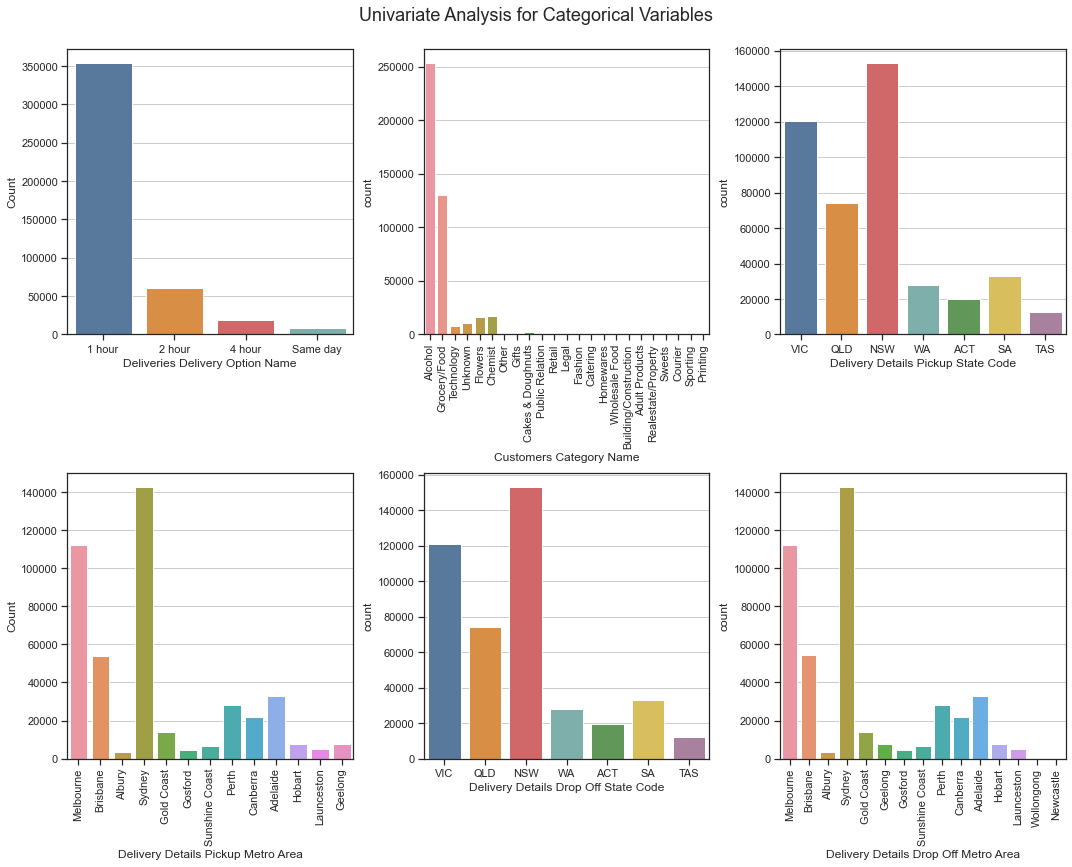

In [44]:
plt.figure(figsize =(15,12))
plt.suptitle("Univariate Analysis for Categorical Variables", fontsize=18, y = 1)
plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.subplot(2,3,1)
sns.countplot(x = 'Deliveries Delivery Option Name', data = sherpa)
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True)

plt.subplot(2,3,2)
sns.countplot(x = 'Customers Category Name', data = sherpa)
plt.xticks(rotation = 90)
plt.gca().yaxis.grid(True)

plt.subplot(2,3,3)
sns.countplot(x = 'Delivery Details Pickup State Code', data = sherpa)
plt.gca().yaxis.grid(True)

plt.subplot(2,3,4)
sns.countplot(x = 'Delivery Details Pickup Metro Area', data = sherpa)
plt.gca().yaxis.grid(True)
plt.ylabel('Count')
plt.xticks(rotation = 90)

plt.subplot(2,3,5)
sns.countplot(x = 'Delivery Details Drop Off State Code', data = sherpa)
plt.gca().yaxis.grid(True)

plt.subplot(2,3,6)
sns.countplot(x = 'Delivery Details Drop Off Metro Area', data = sherpa)
plt.gca().yaxis.grid(True)
plt.xticks(rotation = 90)

plt.tight_layout()
#plt.savefig('categorical.png', dpi = 300)

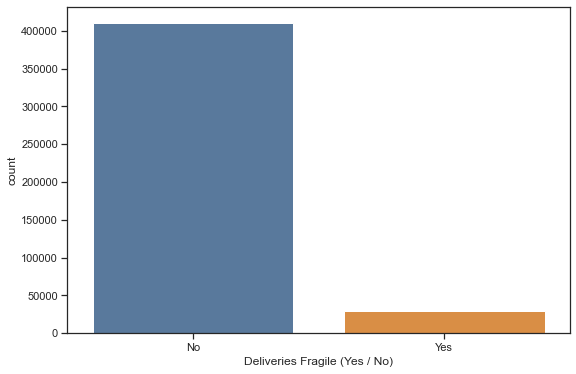

In [45]:
sns.countplot(x='Deliveries Fragile (Yes / No)',data=sherpa)
#plt.savefig('Deliveries Fragile.png')
plt.show()

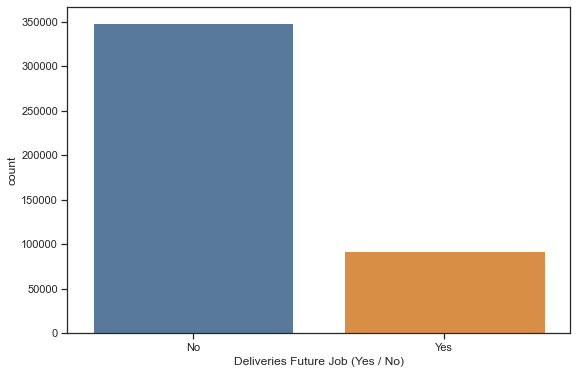

In [46]:
sns.countplot(x='Deliveries Future Job (Yes / No)',data=sherpa)
#plt.savefig('Deliveries Future Job.png')
plt.show()

## 3.2 Bivariate Analysis

To display the relationship between the predictors with the response variables. We will only take a look at the deliveries that are not DIFOT and plot it against the time difference that we have calculated earlier (just for late deliveries - Time Delta)

In [47]:
not_difot = sherpa[sherpa['Time_Delta']!=0]

### 3.2.1 Numerical Variables

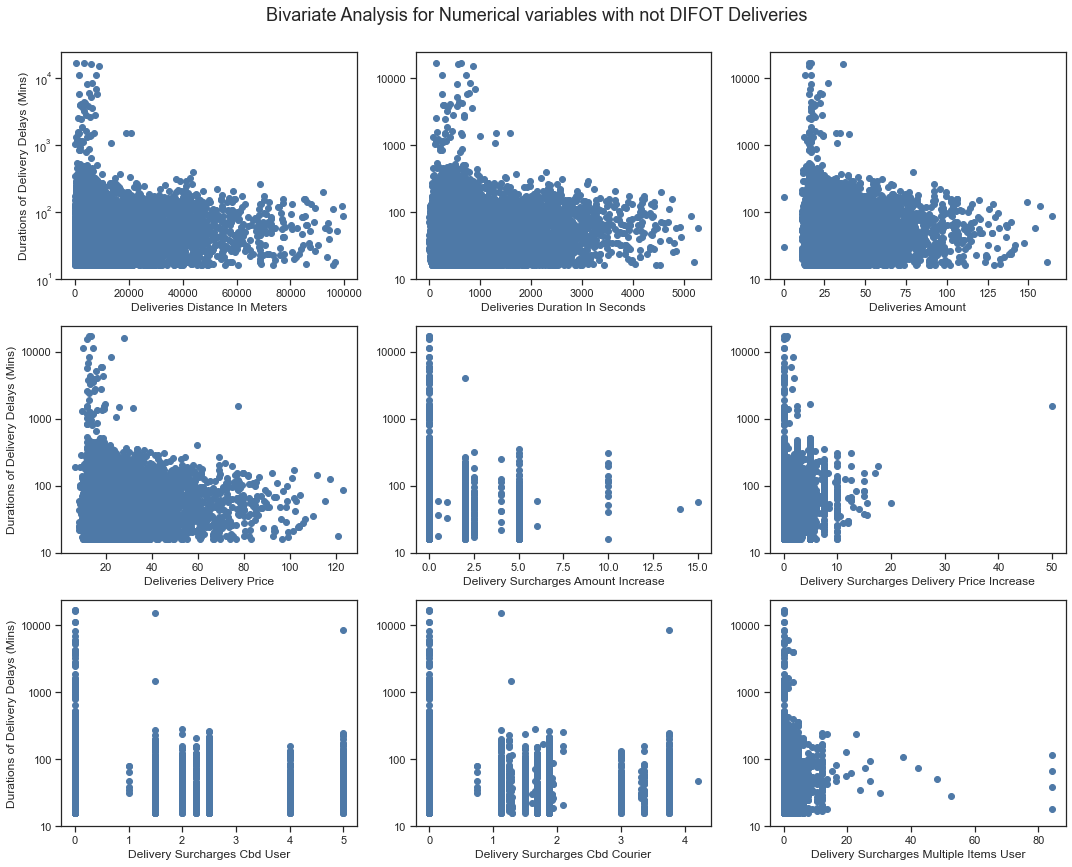

In [48]:
y=[10, 100, 1000, 10000]
values = ['10', '100', '1000', '10000'] 

plt.figure(figsize =(15,12))
plt.suptitle("Bivariate Analysis for Numerical variables with not DIFOT Deliveries", fontsize=18, y = 1)
plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.subplot(3,3,1)
plt.scatter(not_difot['Deliveries Distance In Meters'],not_difot['Time_Delta'] )
plt.xlabel('Deliveries Distance In Meters')
plt.ylabel('Durations of Delivery Delays (Mins)')
plt.yscale('symlog')
plt.ylim(10)
#plt.yticks(y,values)

plt.subplot(3,3,2)
plt.scatter(not_difot['Deliveries Duration In Seconds'],not_difot['Time_Delta'] )
plt.xlabel('Deliveries Duration In Seconds')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,3)
plt.scatter(not_difot['Deliveries Amount'],not_difot['Time_Delta'] )
plt.xlabel('Deliveries Amount')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,4)
plt.scatter(not_difot['Deliveries Delivery Price'],not_difot['Time_Delta'] )
plt.xlabel('Deliveries Delivery Price')
plt.ylabel('Durations of Delivery Delays (Mins)')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,5)
plt.scatter(not_difot['Delivery Surcharges Amount Increase'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Amount Increase')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,6)
plt.scatter(not_difot['Delivery Surcharges Delivery Price Increase'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Delivery Price Increase')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,7)
plt.scatter(not_difot['Delivery Surcharges Cbd User'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Cbd User')
plt.ylabel('Durations of Delivery Delays (Mins)')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,8)
plt.scatter(not_difot['Delivery Surcharges Cbd Courier'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Cbd Courier')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,9)
plt.scatter(not_difot['Delivery Surcharges Multiple Items User'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Multiple Items User')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.tight_layout()
#plt.savefig('conti_notdifot.png', dpi = 300)

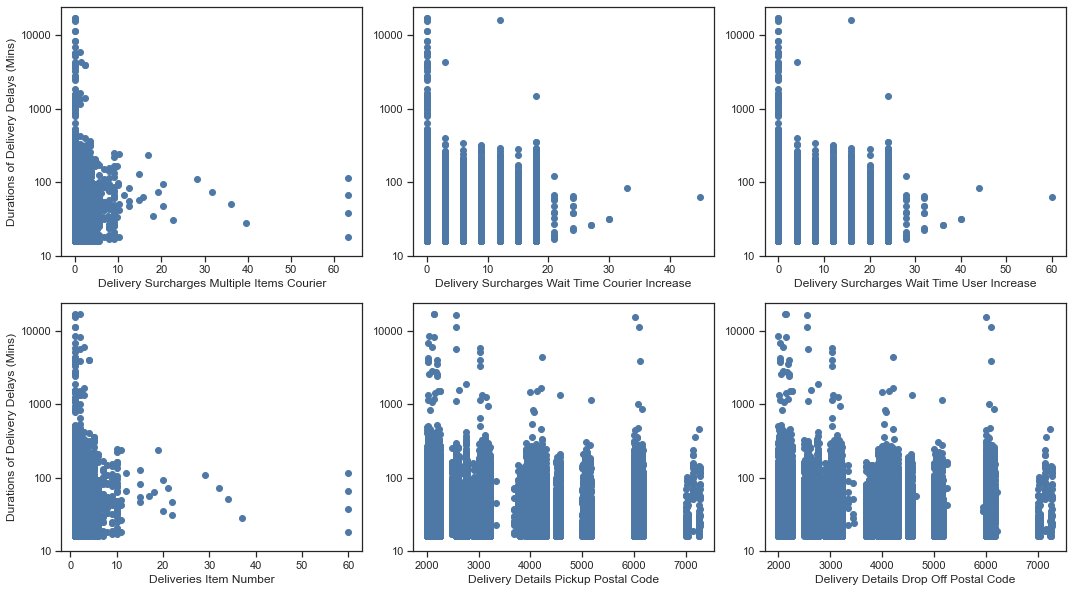

In [49]:
x=[10, 100, 1000, 10000]
values = ['10', '100', '1000', '10000'] 

plt.figure(figsize =(15,12))
plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.plot(range(0, 2000000))
plt.subplot(3,3,1)
plt.scatter(not_difot['Delivery Surcharges Multiple Items Courier'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Multiple Items Courier')
plt.ylabel('Durations of Delivery Delays (Mins)')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,2)
plt.scatter(not_difot['Delivery Surcharges Wait Time Courier Increase'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Wait Time Courier Increase')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,3)
plt.scatter(not_difot['Delivery Surcharges Wait Time User Increase'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Surcharges Wait Time User Increase')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,4)
plt.scatter(not_difot['Deliveries Item Number'],not_difot['Time_Delta'] )
plt.xlabel('Deliveries Item Number')
plt.ylabel('Durations of Delivery Delays (Mins)')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)
           
plt.subplot(3,3,5)
plt.scatter(not_difot['Delivery Details Pickup Postal Code'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Details Pickup Postal Code')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)

plt.subplot(3,3,6)
plt.scatter(not_difot['Delivery Details Drop Off Postal Code'],not_difot['Time_Delta'] )
plt.xlabel('Delivery Details Drop Off Postal Code')
plt.yscale('symlog')
plt.ylim(10)
plt.yticks(y,values)


plt.tight_layout()
#plt.savefig('conti_notdifot2.png', dpi = 300)

### 3.2.2 Categorical Variables

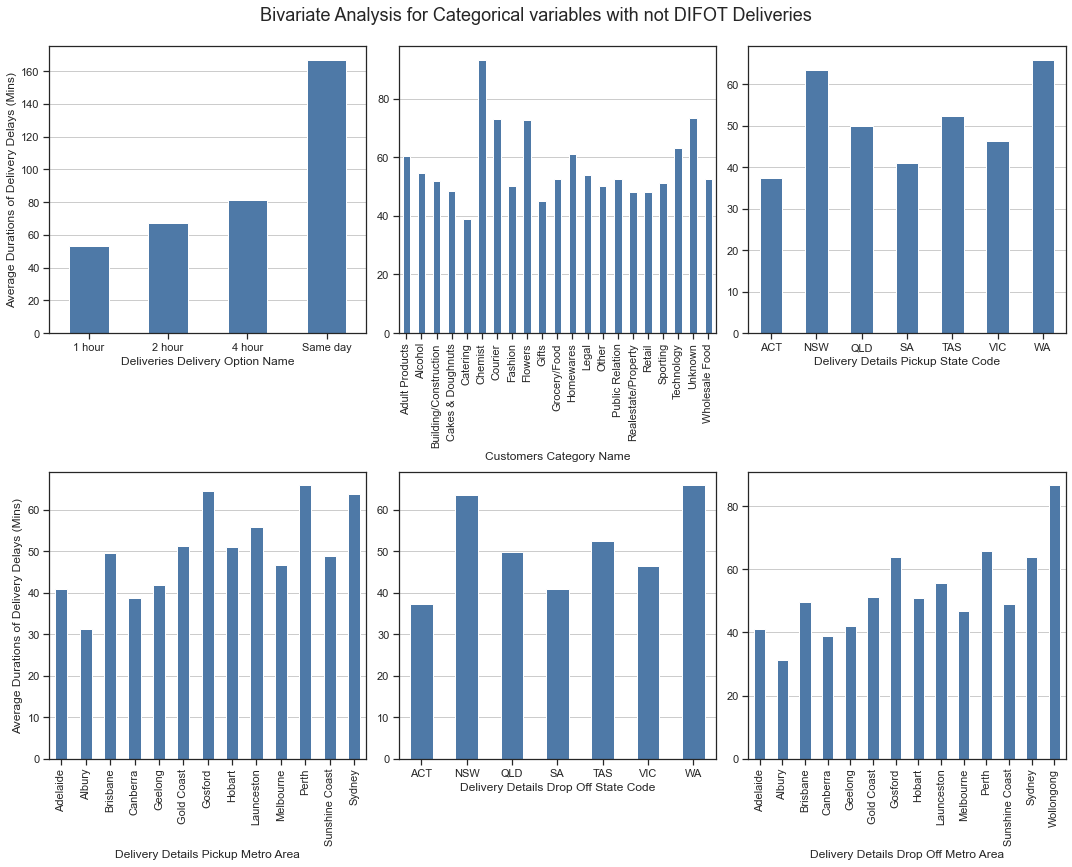

In [50]:
plt.figure(figsize =(15,12))
plt.suptitle("Bivariate Analysis for Categorical variables with not DIFOT Deliveries", fontsize=18, y = 1)
plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.subplot(2,3,1)
not_difot.groupby('Deliveries Delivery Option Name')['Time_Delta'].mean().plot.bar()
plt.ylabel('Average Durations of Delivery Delays (Mins)')
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True)

plt.subplot(2,3,2)
not_difot.groupby('Customers Category Name')['Time_Delta'].mean().plot.bar()
plt.gca().yaxis.grid(True)

plt.subplot(2,3,3)
not_difot.groupby('Delivery Details Pickup State Code')['Time_Delta'].mean().plot.bar()
plt.gca().yaxis.grid(True)
plt.xticks(rotation = 0)

plt.subplot(2,3,4)
not_difot.groupby('Delivery Details Pickup Metro Area')['Time_Delta'].mean().plot.bar()
plt.gca().yaxis.grid(True)
plt.ylabel('Average Durations of Delivery Delays (Mins)')

plt.subplot(2,3,5)
not_difot.groupby('Delivery Details Drop Off State Code')['Time_Delta'].mean().plot.bar()
plt.gca().yaxis.grid(True)
plt.xticks(rotation = 0)

plt.subplot(2,3,6)
not_difot.groupby('Delivery Details Drop Off Metro Area')['Time_Delta'].mean().plot.bar()
plt.gca().yaxis.grid(True)

plt.tight_layout()
#plt.savefig('cat_notdifot.png', dpi = 300)

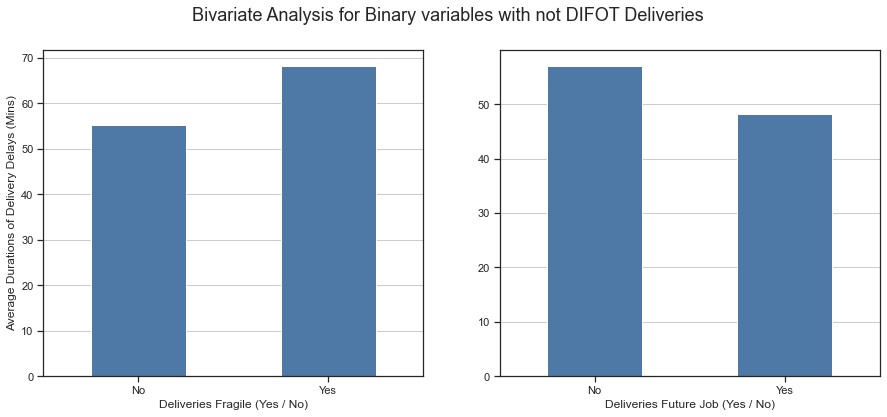

In [51]:
plt.figure(figsize =(15,6))
plt.suptitle("Bivariate Analysis for Binary variables with not DIFOT Deliveries", fontsize=18)
#plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.subplot(1,2,1)
not_difot.groupby('Deliveries Fragile (Yes / No)')['Time_Delta'].mean().plot.bar()
plt.ylabel('Average Durations of Delivery Delays (Mins)')
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True)

plt.subplot(1,2,2)
not_difot.groupby('Deliveries Future Job (Yes / No)')['Time_Delta'].mean().plot.bar()
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True)

#plt.savefig('binary with difot.png', dpi = 300)

In [52]:
not_difot['Delivery Surcharges Insurance User'] = not_difot['Delivery Surcharges Insurance User'].astype(str)

In [53]:
x=[10, 100, 1000, 10000]
values = ['10', '100', '1000', '10000']

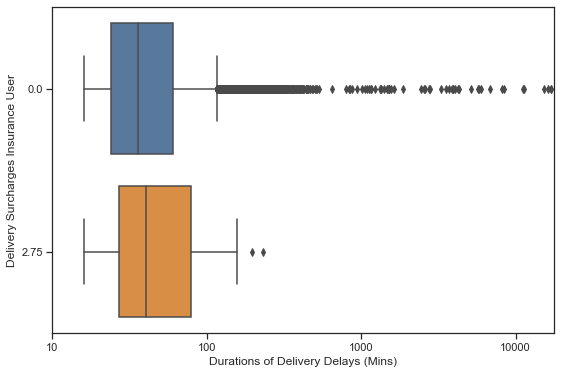

In [54]:
sns.boxplot(y = not_difot['Delivery Surcharges Insurance User'].astype('category'), x = not_difot['Time_Delta'], 
            data=not_difot)
plt.xlabel('Durations of Delivery Delays (Mins)')
plt.xscale('symlog')
plt.xlim(10)
plt.xticks(x,values)
plt.savefig('insuranceboxplot.png', dpi = 300, bbox_inches = 'tight')

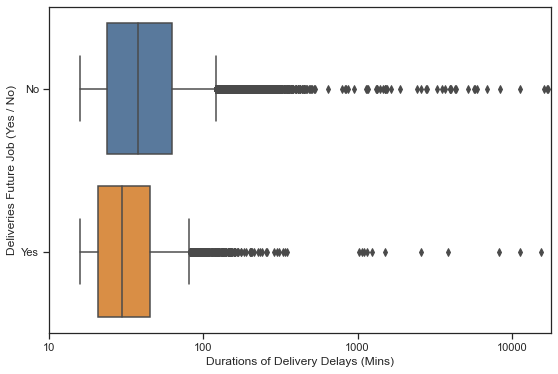

In [55]:
sns.boxplot(y = not_difot['Deliveries Future Job (Yes / No)'].astype('category'), x = not_difot['Time_Delta'], 
            data=not_difot)
plt.xlabel('Durations of Delivery Delays (Mins)')
plt.xscale('symlog')
plt.xlim(10)
plt.xticks(x,values)
plt.savefig('futurejobboxplot.png', dpi = 300, bbox_inches = 'tight')

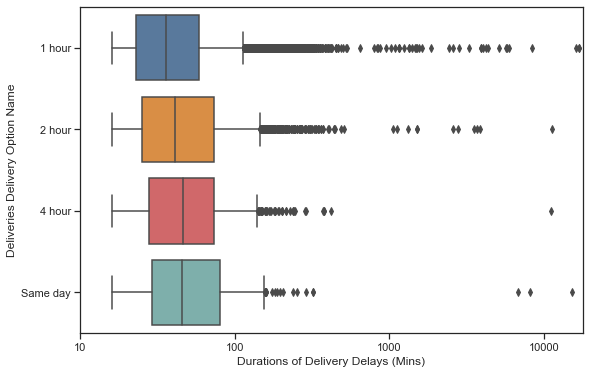

In [56]:
sns.boxplot(y = not_difot['Deliveries Delivery Option Name'].astype('category'), x = not_difot['Time_Delta'], 
            data=not_difot)
plt.xlabel('Durations of Delivery Delays (Mins)')
plt.xscale('symlog')
plt.xlim(10)
plt.xticks(x,values)
plt.savefig('deliveryoptionboxplot.png', dpi = 300, bbox_inches = 'tight')

In [57]:
sherpa = sherpa.drop('Time_Delta', axis = 1)

# 4. Feature Engineering

## 4.1 Log Transformation for some of the continuous variables

- We will only transform 4 of the continuous variables because the other columns have many zero values

In [58]:
variable = ['Deliveries Distance In Meters', 'Deliveries Duration In Seconds', 'Deliveries Amount', 'Deliveries Delivery Price']

col = sherpa[variable]

for name in col:
    sherpa['log_{}'.format(name)] = np.log(sherpa[name] + 1)

In [59]:
sherpa = sherpa.drop(variable, axis = 1)

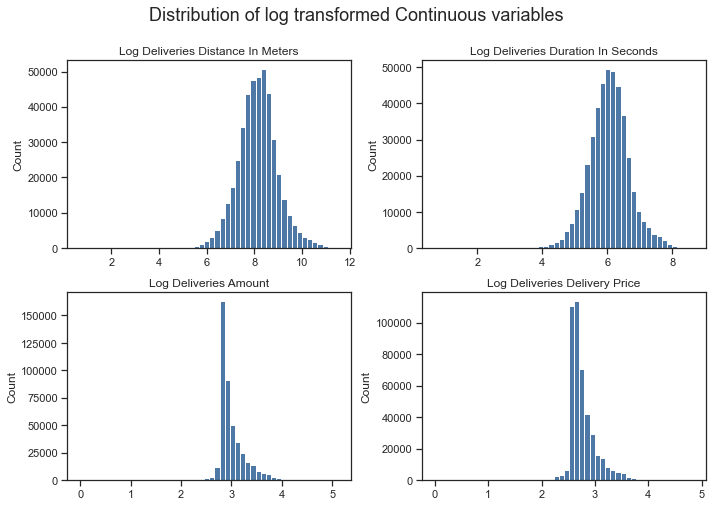

In [60]:
plt.figure(figsize =(10,7))
plt.suptitle("Distribution of log transformed Continuous variables", fontsize=18, y = 1)
plt.subplots_adjust(top = 1.25, bottom= 1.2)

plt.subplot(2,2,1)
plt.hist(sherpa['log_Deliveries Distance In Meters'], bins = 50)
plt.ylabel('Count'); plt.title('Log Deliveries Distance In Meters')

plt.subplot(2,2,2)
plt.hist(sherpa['log_Deliveries Duration In Seconds'], bins = 50)
plt.ylabel('Count'); plt.title('Log Deliveries Duration In Seconds')

plt.subplot(2,2,3)
plt.hist(sherpa['log_Deliveries Amount'], bins = 50)
plt.ylabel('Count'); plt.title('Log Deliveries Amount')

plt.subplot(2,2,4)
plt.hist(sherpa['log_Deliveries Delivery Price'], bins = 50)
plt.ylabel('Count'); plt.title('Log Deliveries Delivery Price')

plt.tight_layout()
plt.savefig('logtransformed.png', dpi = 300,bbox_inches = 'tight' )

## 4.2 Sparse Categories

In [61]:
sherpa['Customers Category Name'].value_counts()

Alcohol                  253703
Grocery/Food             130100
Chemist                   17509
Flowers                   15833
Unknown                   10327
Technology                 7610
Cakes & Doughnuts          2135
Gifts                      1280
Fashion                     525
Other                       478
Adult Products              308
Wholesale Food              196
Legal                       191
Public Relation             182
Retail                      150
Homewares                   113
Building/Construction       100
Sweets                       79
Catering                     42
Realestate/Property          24
Courier                      19
Sporting                      8
Printing                      1
Name: Customers Category Name, dtype: int64

In [62]:
# merge the categories that have low counts into 'other' (less than 1000 counts)
variable = 'Customers Category Name'

counts = sherpa[variable].value_counts() 
for level in counts.index:
    if counts[level] < 1000:
        sherpa.loc[sherpa[variable]==level, variable] = 'Other'

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

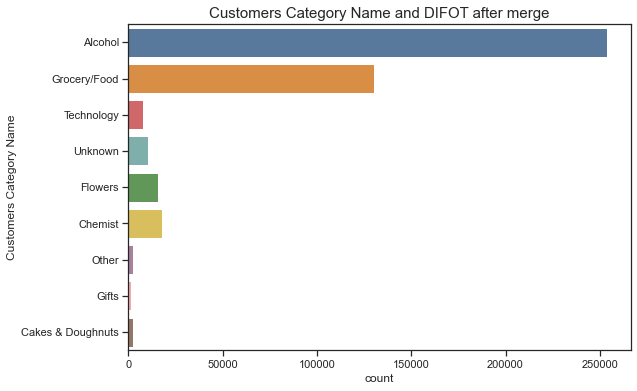

In [63]:
sns.countplot(y='Customers Category Name',data=sherpa)
plt.title('Customers Category Name and DIFOT after merge',fontsize =15)
plt.xticks(rotation = 0)
#plt.savefig('Customers Category Name after merge.png',dpi=200,bbox_inches = 'tight')

## 4.3. Binary Transformation

As can be seen from the boxplot, the Surcharges Insurance User only takes 2 values which is 0 for no Insurance or $2.5 for Insurance. Therefore, to simplity, we will encode this to a dummy variable, taking 0 for no insurance and 1 for delivery with insurance surcharge

In [64]:
sherpa['Delivery Surcharges Insurance User'] = sherpa['Delivery Surcharges Insurance User'].replace([0.00], 0)
sherpa['Delivery Surcharges Insurance User'] = sherpa['Delivery Surcharges Insurance User'].replace([2.75], 1)

In [65]:
sherpa['Delivery Surcharges Insurance User'] = sherpa['Delivery Surcharges Insurance User'].astype(int)

Text(0.5, 1.0, 'Delivery Surcharges Insurance User and DIFOT')

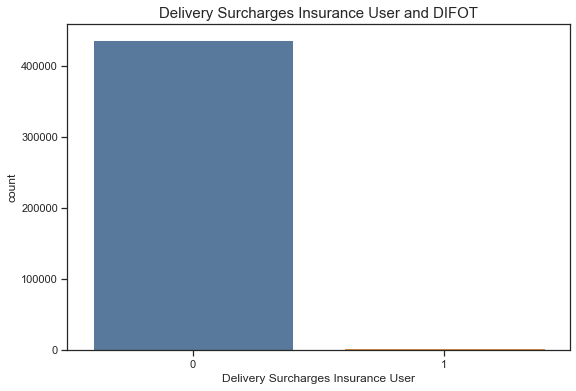

In [66]:
sns.countplot(x='Delivery Surcharges Insurance User',data=sherpa)
plt.title('Delivery Surcharges Insurance User and DIFOT', fontsize = 15)
#plt.savefig('insurance cat.png')

In [67]:
binary = binary + ['Delivery Surcharges Insurance User']

In [68]:
# Tranform the binary variables to numerical variables, taking value of 0 for 'No' categories and 1 for 'Yes' categories.

In [69]:
sherpa['Deliveries Fragile (Yes / No)'] = sherpa['Deliveries Fragile (Yes / No)'].replace(['No'], 0)
sherpa['Deliveries Fragile (Yes / No)'] = sherpa['Deliveries Fragile (Yes / No)'].replace(['Yes'], 1)

In [70]:
sherpa['Deliveries Future Job (Yes / No)'] = sherpa['Deliveries Future Job (Yes / No)'].replace(['No'], 0)
sherpa['Deliveries Future Job (Yes / No)'] = sherpa['Deliveries Future Job (Yes / No)'].replace(['Yes'], 1)

## 4.4 Dummy encoding

In [71]:
keys = {
        '1 hour': 1, # fastest, most costly
        '2 hour': 2, 
        '4 hour': 3, 
        'Same day': 4, # slowest, cheapest
}

ordinal = 'Deliveries Delivery Option Name'
sherpa[ordinal] = sherpa[ordinal].replace(keys)

In [72]:
del_option_dummy = pd.get_dummies(sherpa[ordinal], drop_first = True)

In [73]:
sherpa = pd.concat([sherpa, del_option_dummy], axis = 1)

In [74]:
sherpa = sherpa.rename({2: 'Deliveries Delivery Option 2', 3: 'Deliveries Delivery Option 3',
                                   4:'Deliveries Delivery Option 4'}, axis=1)

In [75]:
sherpa = sherpa.drop('Deliveries Delivery Option Name', axis = 1)

In [76]:
dummy_encoding = ['Customers Category Name', 'Delivery Details Pickup State Code', 'Delivery Details Pickup Metro Area', 
               'Delivery Details Drop Off State Code', 'Delivery Details Drop Off Metro Area']

In [77]:
dummy = pd.get_dummies(sherpa[dummy_encoding], prefix = dummy_encoding, drop_first = True)

In [78]:
sherpa = pd.concat([sherpa, dummy], axis = 1)

In [79]:
sherpa = sherpa.drop(dummy_encoding, axis = 1)

## 4.5 Dummy variables for many zero features

- As we have seen earlier that there quite a few of features that contain many zero values. It will be a problem for logistic regression. Hence, to mitigate this problem, we will create a dummy variables by taking value of 1 if the feature has value of 0 and 0 if it has value >0.

In [80]:
sherpa["zero_amount_increase"] = (sherpa["Delivery Surcharges Amount Increase"] == 0).astype(int)
sherpa["zero_price_increase"] = (sherpa["Delivery Surcharges Delivery Price Increase"] == 0).astype(int)
sherpa["zero_cbd_user"] = (sherpa["Delivery Surcharges Cbd User"] == 0).astype(int)
sherpa["zero_cbd_courier"] = (sherpa["Delivery Surcharges Cbd Courier"] == 0).astype(int)
sherpa["zero_multi_item_user"] = (sherpa["Delivery Surcharges Multiple Items User"] == 0).astype(int)
sherpa["zero_multi_item_courier"] = (sherpa["Delivery Surcharges Multiple Items Courier"] == 0).astype(int)
sherpa["zero_wait_time_courier"] = (sherpa["Delivery Surcharges Wait Time Courier Increase"] == 0).astype(int)
sherpa["zero_wait_time_user"] = (sherpa["Delivery Surcharges Wait Time User Increase"] == 0).astype(int)

# 5. Model Building

- **Taking sampled data**

In [81]:
numerical = ['Delivery Surcharges Amount Increase', 'Delivery Surcharges Delivery Price Increase',
             'Delivery Surcharges Cbd User', 'Delivery Surcharges Cbd Courier',
             'Delivery Surcharges Multiple Items User', 'Delivery Surcharges Multiple Items Courier',
             'Delivery Surcharges Wait Time Courier Increase', 'Delivery Surcharges Wait Time User Increase',
             'Delivery Surcharges Insurance User', 'Deliveries Item Number', 'log_Deliveries Distance In Meters',
             'log_Deliveries Duration In Seconds', 'log_Deliveries Amount', 'log_Deliveries Delivery Price', 
             'Pickup Latitude', 'Pickup Longitude', 'Drop off Latitude', 'Drop off Longitude', 
             'Delivery Details Pickup Postal Code', 'Delivery Details Drop Off Postal Code']

categorical = ['Deliveries Fragile (Yes / No)', 'Deliveries Future Job (Yes / No)', 'zero_amount_increase', 
               'zero_price_increase', 'zero_cbd_user', 'zero_cbd_courier', 'zero_multi_item_user', 
               'zero_multi_item_courier', 'zero_wait_time_courier', 'zero_wait_time_user',
               'Deliveries Delivery Option 2', 'Deliveries Delivery Option 3', 'Deliveries Delivery Option 4',
               'Customers Category Name_Cakes & Doughnuts', 'Customers Category Name_Chemist', 
               'Customers Category Name_Flowers', 'Customers Category Name_Gifts', 
               'Customers Category Name_Grocery/Food', 'Customers Category Name_Other', 
               'Customers Category Name_Technology', 'Customers Category Name_Unknown',
               'Delivery Details Pickup State Code_NSW', 'Delivery Details Pickup State Code_QLD',
               'Delivery Details Pickup State Code_SA', 'Delivery Details Pickup State Code_TAS',
               'Delivery Details Pickup State Code_VIC', 'Delivery Details Pickup State Code_WA',
               'Delivery Details Pickup Metro Area_Albury', 'Delivery Details Pickup Metro Area_Brisbane',
               'Delivery Details Pickup Metro Area_Canberra', 'Delivery Details Pickup Metro Area_Geelong',
               'Delivery Details Pickup Metro Area_Gold Coast', 'Delivery Details Pickup Metro Area_Gosford',
               'Delivery Details Pickup Metro Area_Hobart', 'Delivery Details Pickup Metro Area_Launceston',
               'Delivery Details Pickup Metro Area_Melbourne', 'Delivery Details Pickup Metro Area_Perth',
               'Delivery Details Pickup Metro Area_Sunshine Coast', 'Delivery Details Pickup Metro Area_Sydney',
               'Delivery Details Drop Off State Code_NSW', 'Delivery Details Drop Off State Code_QLD',
               'Delivery Details Drop Off State Code_SA', 'Delivery Details Drop Off State Code_TAS',
               'Delivery Details Drop Off State Code_VIC', 'Delivery Details Drop Off State Code_WA',
               'Delivery Details Drop Off Metro Area_Albury', 'Delivery Details Drop Off Metro Area_Brisbane',
               'Delivery Details Drop Off Metro Area_Canberra', 'Delivery Details Drop Off Metro Area_Geelong',
               'Delivery Details Drop Off Metro Area_Gold Coast', 'Delivery Details Drop Off Metro Area_Gosford',
               'Delivery Details Drop Off Metro Area_Hobart', 'Delivery Details Drop Off Metro Area_Launceston',
               'Delivery Details Drop Off Metro Area_Melbourne', 'Delivery Details Drop Off Metro Area_Newcastle',
               'Delivery Details Drop Off Metro Area_Perth', 'Delivery Details Drop Off Metro Area_Sunshine Coast',
               'Delivery Details Drop Off Metro Area_Sydney', 'Delivery Details Drop Off Metro Area_Wollongong']

predictors = numerical + categorical

In [82]:
#train-test split, 80% train, 20% test
train_indices_sampled, test_indices_sampled= train_test_split(sherpa.index, test_size=0.2, 
                                            stratify=sherpa['DIFOT'], random_state=24)

train_sampled = sherpa.loc[train_indices_sampled,:].copy()
test_sampled =  sherpa.loc[test_indices_sampled,:].copy()

In [83]:
#standardise numerical variables

scaler = StandardScaler()
train_sampled.loc[:, numerical] = scaler.fit_transform(train_sampled.loc[:, numerical])
test_sampled.loc[:, numerical] = scaler.transform(test_sampled.loc[:, numerical])

In [84]:
print("Training set length", len(train_sampled))
print("Tresting set length", len(test_sampled))

Training set length 352730
Tresting set length 88183


- **Taking 10% sample of from the whole dataset**

In [85]:
indices = list(train_sampled.index.copy())

# randomly shuffle the dataset 
np.random.seed(5)
np.random.shuffle(indices) 

sampled_indices = indices[:int(len(indices) * 0.1)] # taking the first 10% of the shuffled training data as the sample 
sampled_dataset = train_sampled.loc[sampled_indices, :].copy() 

print("Sampled set length", len(sampled_dataset))

Sampled set length 35273


In [86]:
n = len(sampled_dataset)
sampled_train_indices, sampled_valid_indices = train_test_split(np.arange(n), test_size=0.2, 
                                                               stratify=sampled_dataset['DIFOT'], random_state=24)

x_train_sampled = train_sampled.drop('DIFOT', axis =1).iloc[sampled_train_indices]
x_valid_sampled = train_sampled.drop('DIFOT', axis =1).iloc[sampled_valid_indices]

y_train_sampled = train_sampled['DIFOT'].iloc[sampled_train_indices]
y_valid_sampled = train_sampled['DIFOT'].iloc[sampled_valid_indices]

In [87]:
print("Training length of sampled data", len(sampled_train_indices))
print("Valid length of sampled data", len(sampled_valid_indices))

Training length of sampled data 28218
Valid length of sampled data 7055


In [88]:
print("Training length of sampled data", len(x_train_sampled))
print("Validiation length of sampled data", len(y_valid_sampled))

Training length of sampled data 28218
Validiation length of sampled data 7055


## 5.1 Logistic Regression

We will be doing feature selection using Lasso to remove redundant features.

- **Feature Selection using Lasso Regression**

In [89]:
param = {'C': [10**-3, 10**-2,10**-1,10**0,10**1,10**2, 10**3]} #hyperparameter

logistic_model = LogisticRegression(penalty='l1', solver='liblinear')
gridsearch_model = GridSearchCV(estimator=logistic_model, param_grid=param)
gridsearch_model.fit(x_train_sampled, y_train_sampled)

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [90]:
# train the logistic regression model using the best parameters from the gridsearch model
lasso_model = LogisticRegression(**gridsearch_model.best_params_, penalty='l1', solver='liblinear')
lasso_model.fit(x_train_sampled, y_train_sampled)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [91]:
importance = np.abs(lasso_model.coef_ ) #absolute value for all the coefficients

In [92]:
print('Total Redundant Features after based on Lasso Regression: {}'.format(np.sum(lasso_model.coef_ ==0)))

Total Redundant Features after based on Lasso Regression: 9


In [93]:
print('List of redundant features: ')
list(pd.Series(x_train_sampled.columns[(importance == 0).ravel()]))

List of redundant features: 


['Drop off Longitude',
 'Delivery Details Pickup Metro Area_Gold Coast',
 'Delivery Details Pickup Metro Area_Hobart',
 'Delivery Details Drop Off State Code_VIC',
 'Delivery Details Drop Off Metro Area_Brisbane',
 'Delivery Details Drop Off Metro Area_Hobart',
 'Delivery Details Drop Off Metro Area_Launceston',
 'Delivery Details Drop Off Metro Area_Newcastle',
 'zero_wait_time_user']

### 5.1.1 Logistic Regression using all of the variables

In [94]:
logit = LogisticRegression(penalty='none')
logit.fit(x_train_sampled, y_train_sampled)

y_pred_valid = logit.predict(x_valid_sampled)

f1_model1 = f1_score(y_valid_sampled, y_pred_valid)
print("F1 score for model 1: {:.4f}".format(f1_model1))

F1 score for model 1: 0.9616


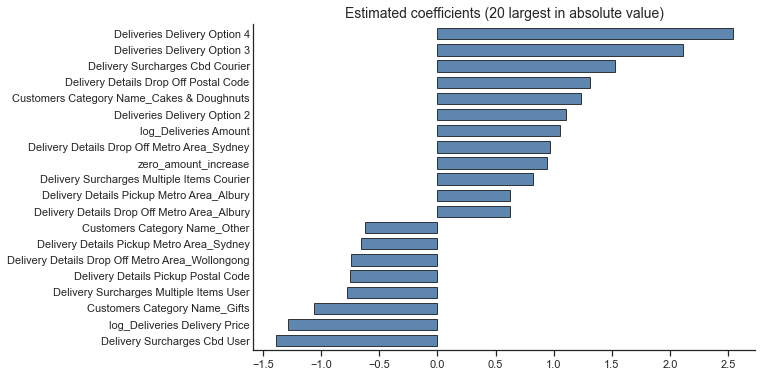

In [95]:
coefplot(logit, x_train_sampled.columns)
plt.savefig('logistic1.png', dpi = 300,bbox_inches = 'tight')
plt.show()

### 5.1.2 Logistic Regression only using the features from Lasso

In [96]:
lasso_features = sherpa.drop(list(pd.Series(x_train_sampled.columns[(importance == 0).ravel()])), axis = 1)

In [97]:
x_train1 = lasso_features.drop('DIFOT', axis =1).iloc[sampled_train_indices]
x_valid1 = lasso_features.drop('DIFOT', axis =1).iloc[sampled_valid_indices]

y_train1 = lasso_features['DIFOT'].iloc[sampled_train_indices]
y_valid1 = lasso_features['DIFOT'].iloc[sampled_valid_indices]

In [98]:
logit_lasso = LogisticRegression(penalty='none')
logit_lasso.fit(x_train1, y_train1)

LogisticRegression(penalty='none')

In [99]:
y_pred_valid1 = logit_lasso.predict(x_valid1)

In [100]:
f1_model2 = f1_score(y_valid1, y_pred_valid1)
print("F1 score for model 2: {:.4f}".format(f1_model2))

F1 score for model 2: 0.9564


In [101]:
name = list(pd.Series(x_train_sampled.columns[(importance > 0).ravel()]))

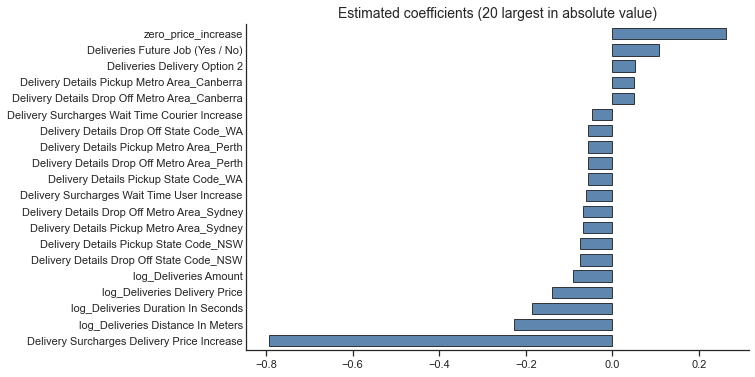

In [102]:
coefplot(logit_lasso, name)
plt.savefig('logistic2.png', dpi = 300, bbox_inches = 'tight')
#plt.show()

## 5.2 Decision Tree Models
- Decision tree models are good for feature selection and robust to outliers, and it has a great interpretability. Thus, it is appropriate for us to try building some trees.
- Entropy is an information theory metric that measures the impurity or uncertainty in a group of observations. It determines how a decision tree chooses to split data. The image below gives a better description of the purity of a set.
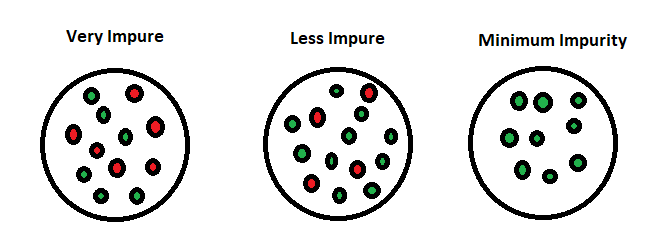
- We can define information gain as a measure of how much information a feature provides about a class. Information gain helps to determine the order of attributes in the nodes of a decision tree.
- The main node is referred to as the parent node, whereas sub-nodes are known as child nodes. We can use information gain to determine how good the splitting of nodes in a decision tree.

- It can help us determine the quality of splitting, as we shall soon see. The calculation of information gain should help us understand this concept better.

- Gain=Eparent−Echildren
- The term Gain represents information gain. Eparent is the entropy of the parent node and E_{children} is the average entropy of the child nodes.

### 5.2.1 Tree model 1

In [103]:
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth = 2, min_samples_leaf = 5, random_state = 0)
tree1.fit(x_train_sampled, y_train_sampled)

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5,
                       random_state=0)

In [104]:
predictions = tree1.predict(x_valid_sampled)
print('F1 score: {:4f}'.format(f1_score(y_valid_sampled, predictions)))

F1 score: 0.960802


### 5.2.2 Tree Model 2 - Tree tune

In [105]:
parameters = {'max_depth': np.arange(1, 20),
              'min_samples_leaf': np.arange(1, 100)}

random_search = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), parameters, n_iter=25, cv=5, scoring='f1', random_state=0)
model = random_search.fit(x_train_sampled, y_train_sampled)

In [106]:
print(random_search.best_params_)
print(random_search.best_score_)

{'min_samples_leaf': 45, 'max_depth': 5}
0.9604338701446249


In [107]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth = 5, min_samples_leaf = 45, random_state = 0)
tree2.fit(x_train_sampled, y_train_sampled)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=45,
                       random_state=0)

In [108]:
predictions = tree2.predict(x_valid_sampled)
print('F1 score: {:.4f}'.format(f1_score(y_valid_sampled, predictions)))

F1 score: 0.9622


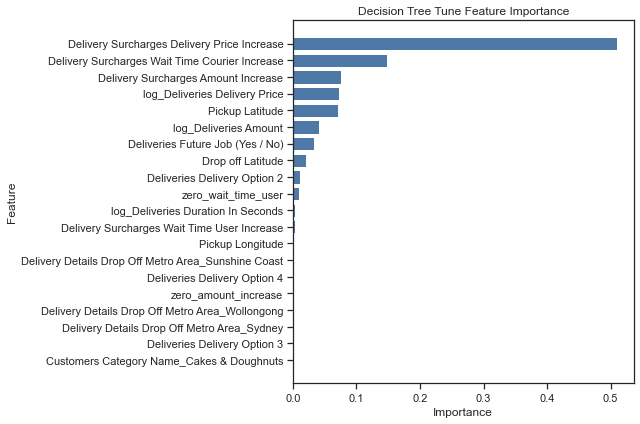

In [109]:
features = x_train_sampled.columns
importances = pd.Series(tree2.feature_importances_, index=features).sort_values()

plt.barh(range(len(importances[-20:])), importances[-20:], tick_label=importances.index[-20:])
plt.title('Decision Tree Tune Feature Importance')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('tree2importances.png', dpi = 300, bbox_inches = 'tight')

### 5.2.3 Tree Model 3 -- considering weight

In [110]:
# tune parameters
parameters = {'max_depth': np.arange(1, 20),
              'min_samples_leaf': np.arange(1, 100),
             'class_weight': [{0:92,1:8}, {0:1,1:1}, {0:8,1:92},{0:11.5,1:1},{0:1,1:11.5}]} # since this dataset is imbalanced. Thus,it better to tune the class_weight.

random_search = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), parameters, n_iter=25, cv=5, scoring='f1', random_state=0)
model = random_search.fit(x_train_sampled, y_train_sampled)

In [111]:
print(random_search.best_params_)
print(random_search.best_score_)

{'min_samples_leaf': 45, 'max_depth': 4, 'class_weight': {0: 1, 1: 1}}
0.9601729408995647


- Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.
- there is a parameter called class_weight with two options to help us address this class imbalance.

In [112]:
tree3 = DecisionTreeClassifier(criterion='entropy', max_depth = 4, min_samples_leaf = 45, class_weight = {0:1,1:1}, random_state = 0)
tree3.fit(x_train_sampled, y_train_sampled)

DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=4, min_samples_leaf=45, random_state=0)

In [113]:
predictions = tree3.predict(x_valid_sampled)
print('F1 score: {:.4f}'.format(f1_score(y_valid_sampled, predictions)))

F1 score: 0.9616


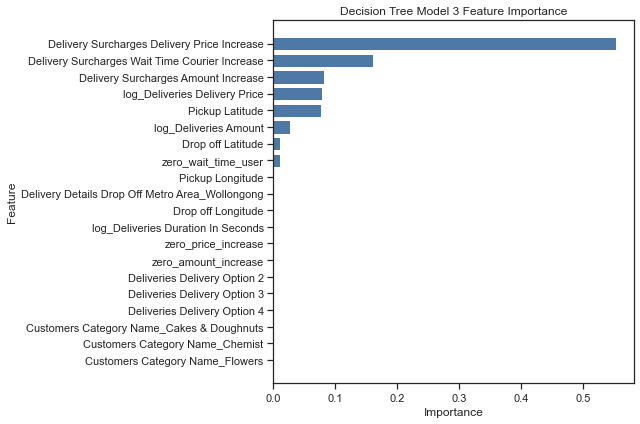

In [114]:
features = x_train_sampled.columns
importances = pd.Series(tree3.feature_importances_, index=features).sort_values()

plt.barh(range(len(importances[-20:])), importances[-20:], tick_label=importances.index[-20:])
plt.title('Decision Tree Model 3 Feature Importance')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('tree3.png', dpi = 300)

## 5.2.3 Tree pruning

In [115]:
path = tree2.cost_complexity_pruning_path(x_train_sampled, y_train_sampled)
alphas = path.ccp_alphas

In [116]:
model = tree2

parameters = {'max_depth': np.arange(1, 20),
              'min_samples_leaf': np.arange(1, 100),
              'ccp_alpha': alphas,
             'class_weight': [{0:92,1:8}, {0:1,1:1}, {0:8,1:92}]}

tree_search = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), parameters, n_iter=25, cv=5, scoring='f1', random_state=0)
model = tree_search.fit(x_train_sampled, y_train_sampled)

In [117]:
predictions = model.predict(x_valid_sampled)
print('F1 score: {:.4f}'.format(f1_score(y_valid_sampled, predictions)))

F1 score: 0.9623


In [118]:
tree = tree_search.best_estimator_

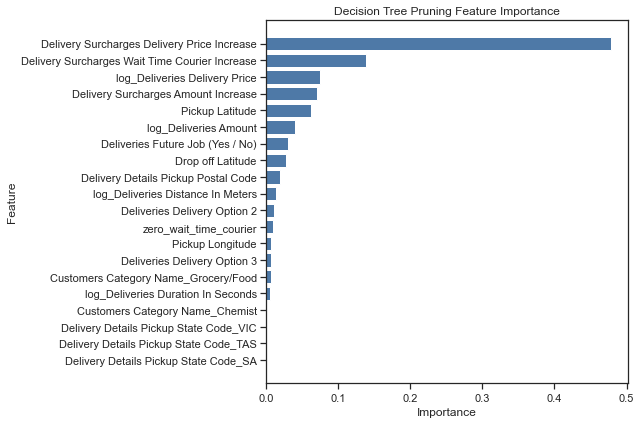

In [119]:
features = x_train_sampled.columns
importances = pd.Series(tree.feature_importances_, index=features).sort_values()

plt.barh(range(len(importances[-20:])), importances[-20:], tick_label=importances.index[-20:])
plt.title('Decision Tree Pruning Feature Importance')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('treepruningimportances.png')

In [120]:
import graphviz

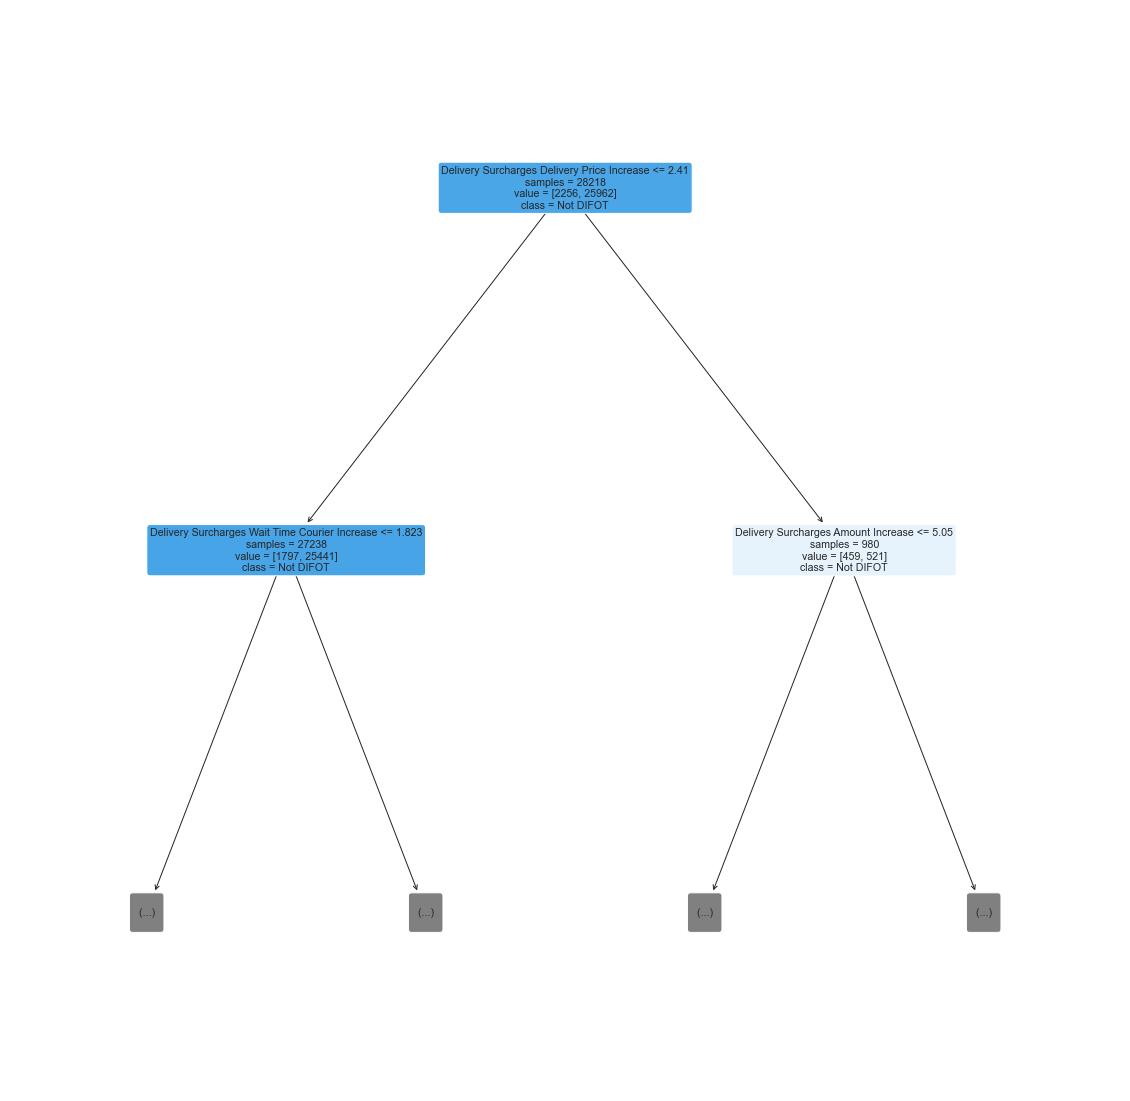

<Figure size 648x432 with 0 Axes>

In [121]:
plt.figure(figsize=(20, 20))
plot_tree(tree, max_depth = 1, feature_names = features, class_names=['DIFOT','Not DIFOT'], impurity=False,
          rounded=True, filled = True)
plt.show()
plt.savefig('Decision Tree.png',dpi=1000,bbox_inches = 'tight')

## 5.3 Random Forest

### 5.3.1 Optuna method

In [122]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features=3, min_samples_leaf=5)
rf.fit(x_train_sampled, y_train_sampled)

RandomForestClassifier(criterion='entropy', max_features=3, min_samples_leaf=5)

In [123]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    
    model = RandomForestClassifier(n_estimators=100,
                                   criterion=criterion,  
                                   max_features=max_features, 
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=1)
    
    scores = cross_val_score(model, x_train_sampled, y_train_sampled, cv=5, scoring='accuracy')
    loss = 1 - np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=60, timeout=600) 

[I 2022-05-08 23:17:25,459] A new study created in memory with name: no-name-4f4129ac-784b-45fd-931e-edbae7959490
[I 2022-05-08 23:17:41,990] Trial 0 finished with value: 0.075731829340692 and parameters: {'criterion': 'gini', 'min_samples_leaf': 15, 'max_features': 12}. Best is trial 0 with value: 0.075731829340692.
[I 2022-05-08 23:18:15,198] Trial 1 finished with value: 0.0770075642972804 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 18}. Best is trial 0 with value: 0.075731829340692.
[I 2022-05-08 23:18:46,849] Trial 2 finished with value: 0.08072858089643498 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 20}. Best is trial 0 with value: 0.075731829340692.
[I 2022-05-08 23:18:56,663] Trial 3 finished with value: 0.07796439534288768 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 4, 'max_features': 4}. Best is trial 0 with value: 0.075731829340692.
[I 2022-05-08 23:19:06,720] Trial 4 finished with value: 0.

In [124]:
params = study.best_params
params

{'criterion': 'gini', 'min_samples_leaf': 11, 'max_features': 20}

In [125]:
params = {'criterion': 'gini', 'min_samples_leaf':11, 'max_features': 20}

In [126]:
# **params "unpacks" the dictionary and passes the items as inputs to the random forest classifier
    
rf = RandomForestClassifier(n_estimators=3000, **params)
rf.fit(x_train_sampled, y_train_sampled)

RandomForestClassifier(max_features=20, min_samples_leaf=11, n_estimators=3000)

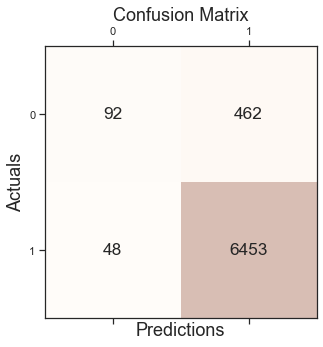

In [127]:
# confusion matrix 

rf_pred = rf.predict(x_valid_sampled)

# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_valid_sampled, y_pred=rf_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('confusionmatrixrandom.png', dpi = 300, bbox_inches = 'tight')
#plt.show()

In [128]:
# F1 score
random_forestf1 = f1_score(y_valid_sampled, rf_pred)
print('F1 Score: {:.4f}'.format(random_forestf1))

F1 Score: 0.9620


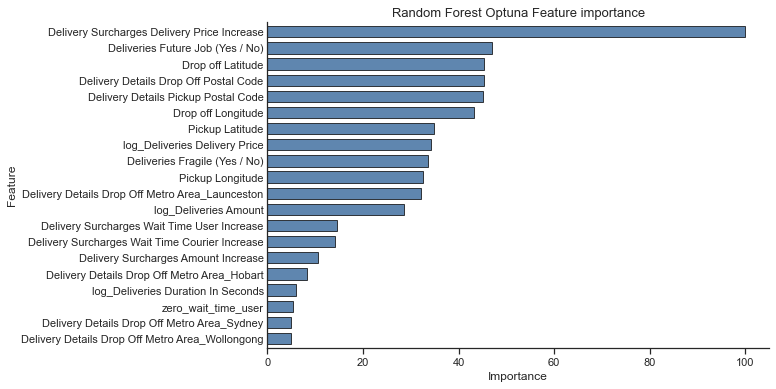

In [129]:
# Feature importance

def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Random Forest Optuna Feature importance', fontsize=13)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    sns.despine()
    return fig, ax

plot_feature_importance(rf, predictors)
plt.savefig('random_feature.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### 5.3.2 Calibrated RF 

In [130]:
from sklearn.calibration import calibration_curve

def plot_calibration_curves(y_true, y_prob, labels=None):
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    if y_prob.ndim==1:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
        if labels:
            ax.plot(prob_pred, prob_true, label=labels)
    else: 
        m = y_prob.shape[1]
        for i in range(m):
            prob_true, prob_pred = calibration_curve(y_true, y_prob[:,i], n_bins=10)
            if labels:
                ax.plot(prob_pred, prob_true, label=labels[i])
            else:
                ax.plot(prob_pred, prob_true)
    
    ax.plot([0,1],[0,1], linestyle='--', color='black', alpha=0.5)

    ax.set_xlabel('Estimated probability')
    ax.set_ylabel('Empirical probability')
    if y_prob.ndim==1:
        ax.set_title('Reliability curve', fontsize=14)
    else:
        ax.set_title('Reliability curves', fontsize=14)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize=13, frameon=False)
    sns.despine()

    return fig, ax

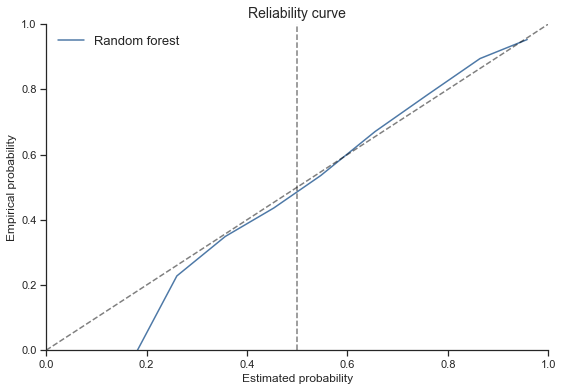

In [131]:
from sklearn.model_selection import cross_val_predict

y_prob = cross_val_predict(rf, x_train_sampled, y_train_sampled, cv = 5, method='predict_proba')[:,1]
fig, ax = plot_calibration_curves(y_train_sampled, y_prob, labels='Random forest')
ax.axvline(0.5, color='black', linestyle='dashed', alpha = 0.5) # decision threshold

plt.savefig('calibratedrf.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [132]:
#%%time 
from sklearn.calibration import CalibratedClassifierCV
calibrated_rf = CalibratedClassifierCV(rf, cv = 5, method='isotonic') 
calibrated_rf.fit(x_train_sampled, y_train_sampled)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_features=20,
                                                             min_samples_leaf=11,
                                                             n_estimators=3000),
                       cv=5, method='isotonic')

In [133]:
rf_calib_pred = calibrated_rf.predict(x_valid_sampled)

In [134]:
# f1 score for calibrated RF

print('F1 Score: %.4f' % f1_score(y_valid_sampled, rf_calib_pred))

F1 Score: 0.9618


## 5.4 Boosting 

In [135]:
gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, n_estimators= 1901, subsample = 0.596)
gb_model = gb.fit(x_train_sampled, y_train_sampled)
predict_boosting = gb_model.predict(x_valid_sampled)
gb_f1 = f1_score(y_valid_sampled, predict_boosting)

In [136]:
print('F1 score: {:.4f}'.format(gb_f1))

F1 score: 0.9612


In [137]:
def plot_feature_import(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Gradient Boosting Feature importance', fontsize=13)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    sns.despine()
    return fig, ax

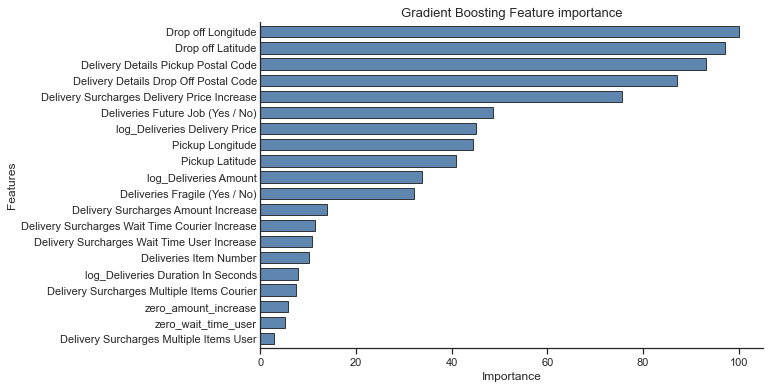

In [138]:
plot_feature_import(gb, predictors)
plt.savefig('gradientboosting.png', dpi = 300,bbox_inches = 'tight' )
plt.show()

# F1 Score

In [139]:
data = {'Modelling':['Logistic Regression','Random Forest','Calibrated Random Forest','Decision Tree Model 1','Decision Tree Tune', 
                     'Decision Tree Model 2','Decision Tree Pruning','Gradient Boosting','Logistic Regression after feature selection using Lasso'],
        'F1-Score':[f1_model1,random_forestf1,0.9618,0.9608,0.9622,0.9616,0.9623,0.9612,f1_model2]}

f1_score = pd.DataFrame(data)
f1_score

,Modelling,F1-Score
0,Logistic Regression,0.961627
1,Random Forest,0.961986
2,Calibrated Random Forest,0.961800
3,Decision Tree Model 1,0.960800
4,Decision Tree Tune,0.962200
5,Decision Tree Model 2,0.961600
6,Decision Tree Pruning,0.962300
7,Gradient Boosting,0.961200
8,Logistic Regression after feature selection us...,0.956411


In [142]:
columns=['Estimated risk', 'SE', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic Regression after feature selection using Lasso']
results2=pd.DataFrame(0.0, columns=columns, index=rows) 
tau=2/3

methods=[logit_lasso]

y_prob = np.zeros((len(y_valid1), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(x_valid1)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  5*((y_pred!=y_valid1) & (y_pred==0)) + 1*((y_pred!=y_valid1) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid1, y_pred).ravel() 

    results2.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results2.iloc[i,1] =  np.std(loss)/np.sqrt(len(loss))
    results2.iloc[i,2] =  accuracy_score(y_valid1, y_pred)
    results2.iloc[i,3] =  tp/(tp+fn)
    results2.iloc[i,4] =  tn/(tn+fp)
    results2.iloc[i,5] =  precision_score(y_valid1, y_pred)
    results2.iloc[i,6] =  roc_auc_score(y_valid1, y_prob[:,i])
    results2.iloc[i,7] =  log_loss(y_valid1, y_prob[:,i])

results2.round(3)

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic Regression after feature selection using Lasso,0.167,0.009,0.916,0.977,0.265,0.933,0.756,0.251


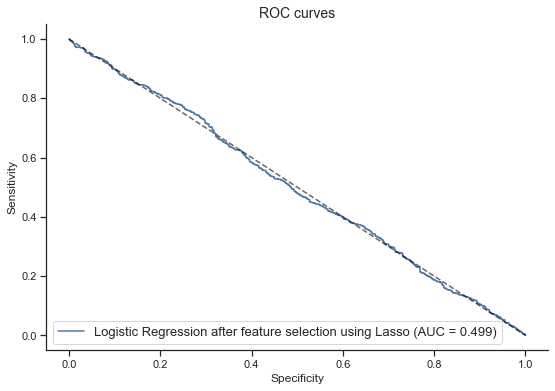

In [145]:
def plot_roc_curves(y_test_sampled, y_probs, labels, sample_weight=None):
    
    fig, ax= plt.subplots(figsize=(9,6))

    N, M=  y_probs.shape

    for i in range(M):
        fpr, tpr, _ = roc_curve(y_test_sampled, y_probs[:,i], sample_weight=sample_weight)
        auc = roc_auc_score(y_test_sampled, y_probs[:,i], sample_weight=sample_weight)
        ax.plot(1-fpr, tpr, label=labels.iloc[i] + ' (AUC = {:.3f})'.format(auc))
    
    ax.plot([0,1],[1,0], linestyle='--', color='black', alpha=0.6)

    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    ax.set_title('ROC curves', fontsize=14)
    sns.despine()

    plt.legend(fontsize=13, loc ='lower left' )
    
    return fig, ax

# ROC curve

fig, ax = plot_roc_curves(y_valid_sampled, y_prob, labels=pd.Series(rows))
plt.show()

In [146]:
columns=['Estimated risk', 'SE', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic Regression','Decision Tree Model 1', 'Decision Tree Tune', 
                     'Decision Tree Model 2', 'Decision Tree Pruning',
                     'Random Forest', 'Calibrated Random Forest', 'Gradient Boosting']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
tau=2/3

methods=[logit, tree1, tree2, tree3,model,rf,calibrated_rf,gb_model]

y_prob = np.zeros((len(y_valid_sampled), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(x_valid_sampled)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  5*((y_pred!=y_valid_sampled) & (y_pred==0)) + 1*((y_pred!=y_valid_sampled) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid_sampled, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(loss))
    results.iloc[i,2] =  accuracy_score(y_valid_sampled, y_pred)
    results.iloc[i,3] =  tp/(tp+fn)
    results.iloc[i,4] =  tn/(tn+fp)
    results.iloc[i,5] =  precision_score(y_valid_sampled, y_pred)
    results.iloc[i,6] =  roc_auc_score(y_valid_sampled, y_prob[:,i])
    results.iloc[i,7] =  log_loss(y_valid_sampled, y_prob[:,i])

results.round(3)

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic Regression,0.126,0.007,0.925,0.986,0.215,0.936,0.760,0.231
Decision Tree Model 1,0.119,0.007,0.926,0.988,0.197,0.935,0.635,0.246
Decision Tree Tune,0.129,0.007,0.926,0.985,0.226,0.937,0.726,0.236
Decision Tree Model 2,0.136,0.008,0.925,0.983,0.236,0.938,0.714,0.239
Decision Tree Pruning,0.130,0.007,0.925,0.985,0.227,0.937,0.740,0.234
Random Forest,0.137,0.008,0.926,0.983,0.260,0.940,0.756,0.232
Calibrated Random Forest,0.134,0.008,0.926,0.984,0.253,0.939,0.759,0.231
Gradient Boosting,0.165,0.009,0.920,0.977,0.245,0.938,0.762,0.238


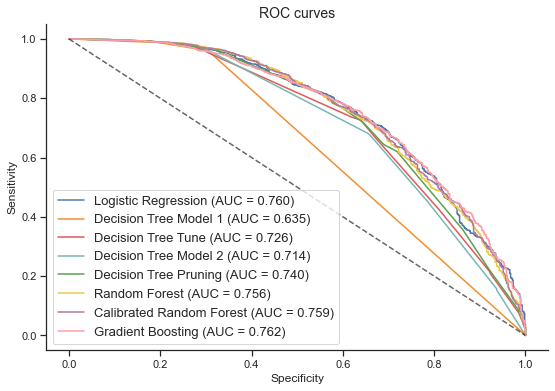

In [147]:
def plot_roc_curves(y_test_sampled, y_probs, labels, sample_weight=None):
    
    fig, ax= plt.subplots(figsize=(9,6))

    N, M=  y_probs.shape

    for i in range(M):
        fpr, tpr, _ = roc_curve(y_test_sampled, y_probs[:,i], sample_weight=sample_weight)
        auc = roc_auc_score(y_test_sampled, y_probs[:,i], sample_weight=sample_weight)
        ax.plot(1-fpr, tpr, label=labels.iloc[i] + ' (AUC = {:.3f})'.format(auc))
    
    ax.plot([0,1],[1,0], linestyle='--', color='black', alpha=0.6)

    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    ax.set_title('ROC curves', fontsize=14)
    sns.despine()

    plt.legend(fontsize=13, loc ='lower left' )
    
    return fig, ax

# ROC curve

fig, ax = plot_roc_curves(y_valid_sampled, y_prob, labels=pd.Series(rows))
plt.show()

In [148]:
frames = [results, results2]
  
model_evaluation= pd.concat(frames)
model_evaluation

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic Regression,0.126152,0.007224,0.925443,0.986002,0.214801,0.936450,0.760229,0.230636
Decision Tree Model 1,0.119064,0.006827,0.925726,0.987848,0.196751,0.935197,0.634512,0.245662
Decision Tree Tune,0.128845,0.007381,0.925585,0.985233,0.225632,0.937226,0.725522,0.236315
Decision Tree Model 2,0.136499,0.007753,0.924734,0.983387,0.236462,0.937940,0.714190,0.238520
Decision Tree Pruning,0.130120,0.007445,0.925443,0.984925,0.227437,0.937344,0.740393,0.234063
Random Forest,0.136782,0.007832,0.926152,0.982926,0.259928,0.939706,0.755928,0.232317
Calibrated Random Forest,0.133806,0.007683,0.926293,0.983695,0.252708,0.939198,0.758836,0.230645
Gradient Boosting,0.164848,0.008910,0.919631,0.977080,0.245487,0.938257,0.761919,0.238208
Logistic Regression after feature selection using Lasso,0.167116,0.008854,0.915663,0.977343,0.265139,0.933452,0.755732,0.251407


In [149]:
f1 = [0.9616, 0.9608, 0.9622, 0.9616, 0.9623, 0.9620, 0.9618,0.9612, 0.9564]
 
model_evaluation['F1-Score'] = f1

In [150]:
model_evaluation

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-Score
Logistic Regression,0.126152,0.007224,0.925443,0.986002,0.214801,0.936450,0.760229,0.230636,0.9616
Decision Tree Model 1,0.119064,0.006827,0.925726,0.987848,0.196751,0.935197,0.634512,0.245662,0.9608
Decision Tree Tune,0.128845,0.007381,0.925585,0.985233,0.225632,0.937226,0.725522,0.236315,0.9622
Decision Tree Model 2,0.136499,0.007753,0.924734,0.983387,0.236462,0.937940,0.714190,0.238520,0.9616
Decision Tree Pruning,0.130120,0.007445,0.925443,0.984925,0.227437,0.937344,0.740393,0.234063,0.9623
Random Forest,0.136782,0.007832,0.926152,0.982926,0.259928,0.939706,0.755928,0.232317,0.9620
Calibrated Random Forest,0.133806,0.007683,0.926293,0.983695,0.252708,0.939198,0.758836,0.230645,0.9618
Gradient Boosting,0.164848,0.008910,0.919631,0.977080,0.245487,0.938257,0.761919,0.238208,0.9612
Logistic Regression after feature selection using Lasso,0.167116,0.008854,0.915663,0.977343,0.265139,0.933452,0.755732,0.251407,0.9564


In [151]:
model_evaluation.to_csv('model evaluation scores.csv')

In [152]:
# based on f1 score, the best model is the tree pruning.

In [153]:
model = tree_search.fit(train_sampled.drop(['DIFOT'],axis=1), train_sampled['DIFOT'])

In [154]:
predictions = model.predict(test_sampled.drop(['DIFOT'],axis=1))
print('F1 score: {:.4f}'.format(f1_score(test_sampled['DIFOT'], predictions)))

F1 score: 0.9613
